# Medical Image Detection using Convolutional Neural Networks

In [ ]:
!pip install Augmentor

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import random
import shutil
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import cv2
import Augmentor
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:

# Assuming 'img_data.zip' contains the directory 'img_data'
source = "/content/drive/MyDrive/archive.zip"
destination = os.path.join(os.getcwd(), "data")

# Extract the zip file to the destination directory
with zipfile.ZipFile(source, 'r') as zip_ref:
    zip_ref.extractall(destination)

# Optionally, remove the zip file after extraction
# os.remove(source)

In [ ]:
print(destination)

/content/data


In [ ]:
# Subcategory of medical images
print("Categories of Medical images: ")
for folder in os.listdir(destination):

    if os.path.isdir(os.path.join(destination, folder)):
        print(folder, end="\t")

Categories of Medical images: 
Hand	AbdomenCT	CXR	BreastMRI	HeadCT	ChestCT	

In [ ]:
print("Number of images in each subdirectory: ")
for folder in os.listdir(destination):
    temp_path = os.path.join(destination, folder)
    if os.path.isdir(temp_path):
        temp_list = os.listdir(temp_path)
        count = 0
        for file in temp_list:
            if not os.path.isdir(os.path.join(temp_path, file)):
                count += 1
    print(folder," : ",count)

Number of images in each subdirectory: 
Hand  :  10000
AbdomenCT  :  10000
CXR  :  10000
BreastMRI  :  8954
HeadCT  :  10000
ChestCT  :  10000


From the above output it is clear that the dataset is balanced(almost). Each category has 10000 images except the BreastMRI  class which has 8954 images. As the difference isn't huge it is not going to be a problem. Beside that, image augmentation will eliminate the problem easily.

In [ ]:
# Create a list of path of all subdirectories
def get_path_subdir(destination):
    paths = []
    for folder in os.listdir(destination):
        folder_path = os.path.join(destination, folder)
        if os.path.isdir(folder_path):
            paths.append(folder_path)
    return paths

In [ ]:
get_path_subdir(destination)

['/content/data/Hand',
 '/content/data/AbdomenCT',
 '/content/data/CXR',
 '/content/data/BreastMRI',
 '/content/data/HeadCT',
 '/content/data/ChestCT']

In [ ]:
# Pick five random image from all the images of the subdirectory
def pick_image(dir_path):
    file_paths = []
    for file in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file)
        if not os.path.isdir(file_path):
            file_paths.append(file_path)
    image_paths = set()
    while len(image_paths) < 4:
        image_paths.add(np.random.randint(0,len(file_paths)-1))
    image_paths = [file_paths[i] for i in list(image_paths)]
    return image_paths

In [ ]:
# Initialize some variables
columns = 2
rows = 2
# plot images
def plot_images(image_paths):
    fig = plt.figure(figsize=(15, 10))
    for idx in range(len(image_paths)):
        path = image_paths[idx]
        fig.add_subplot(rows, columns, idx+1)
        image = cv2.imread(path)
        plt.imshow(image)
        plt.axis('off')
    plt.show()

In [ ]:
# Get path of all subdirectory amnd store in a list
dir_paths = get_path_subdir(destination)
dir_paths

['/content/data/Hand',
 '/content/data/AbdomenCT',
 '/content/data/CXR',
 '/content/data/BreastMRI',
 '/content/data/HeadCT',
 '/content/data/ChestCT']

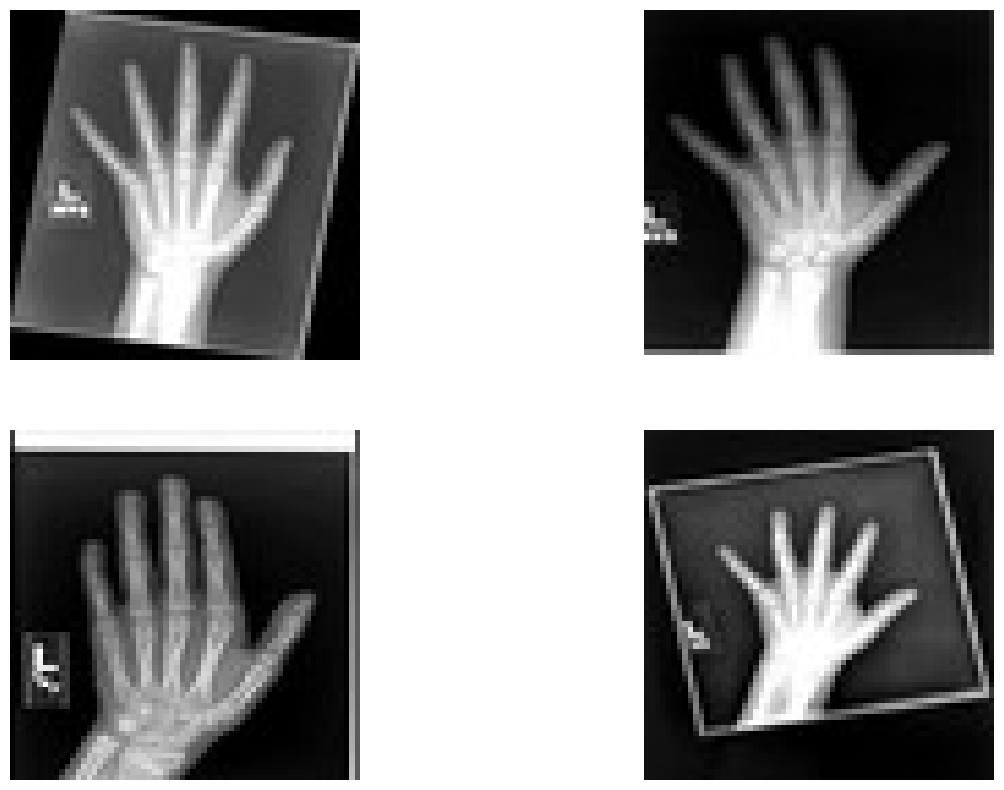

In [ ]:
# Pick four images randomly and plot it
image_paths = pick_image(dir_paths[0])
plot_images(image_paths)

From the above diagrams it's clear that the images are similar to X-rayimages  and although the images have three channels, the images looks like Greyscale images. If we see the images carefully we can only find that there is only white and black shades in the image or more precisely the image only consists grey shades. As, the images has no color then converting the image to greyscale can't lead to a huge amount of loss of information.

Create Test Image Dataset

In [ ]:
# Create test folder
os.mkdir(os.path.join(os.getcwd(), "test"))

In [ ]:
# Create subdirectory
for dir_names in dir_paths:
    os.mkdir(os.path.join(os.getcwd(), "test", dir_names.split('/')[-1]))

In [ ]:
for dir_names in dir_paths:
    print((dir_names))
    print((dir_names.split('/')[-1]))

/content/data/Hand
Hand
/content/data/AbdomenCT
AbdomenCT
/content/data/CXR
CXR
/content/data/BreastMRI
BreastMRI
/content/data/HeadCT
HeadCT
/content/data/ChestCT
ChestCT


In [ ]:
# Get test images randomly from the dataset
for dir_names in dir_paths:
    for i in range(300):
        file_name = random.choice(os.listdir(dir_names))
        shutil.move(os.path.join(dir_names, file_name), os.path.join(os.getcwd(), "test", dir_names.split('/')[-1], file_name))

A common mistake is done by many is using testing data for validation which is not a great practice. it leads to data leakage. The test data schould be unseen to the model. Therefore, I am randomly picking almost 300 images from each class and store in different folders which will not be used neither as training data nor validation data.
Another thing one needs to keep in mind that test data should be splited before anytype of preocessing applied to the dataset. Therefore, any type of preprocessing or regularization should be applied after splitting test set.

Image Augmentation

In [ ]:
# Create a pipeline
augmentor = Augmentor.Pipeline("data", os.path.join(os.getcwd(), "augmented_data"))

Initialised with 57154 image(s) found.
Output directory set to /content/augmented_data.

In [ ]:
# Rotation
augmentor.rotate(probability=0.5, max_left_rotation=3, max_right_rotation=3)

In [ ]:
# Flip
augmentor.flip_left_right(probability=0.3)
augmentor.flip_top_bottom(probability=0.3)
augmentor.rotate90(probability=0.3)
augmentor.rotate180(probability=0.3)
augmentor.rotate270(probability=0.3)

In [ ]:
# Skew
augmentor.skew_tilt(probability=0.3)
augmentor.skew_left_right(probability=0.3)
augmentor.skew_top_bottom(probability=0.3)
augmentor.skew_corner(probability=0.3)
augmentor.skew(probability=0.5)

In [ ]:
# Mirror
augmentor.flip_left_right(probability=0.5)
augmentor.flip_top_bottom(probability=0.3)
augmentor.flip_random(probability=0.3)

In [ ]:
# Random Brightness
augmentor.random_brightness(probability = 0.5, min_factor=0.4, max_factor=0.9)

In [ ]:
# Random Contrast
augmentor.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.4)

In [ ]:
# Random Distortion
augmentor.random_distortion(probability=0.5, grid_width=3, grid_height=3, magnitude=3)

In [ ]:
# Random Erasing
augmentor.random_erasing(probability=0.5, rectangle_area=0.2)

In [ ]:
# Zoom
augmentor.zoom(probability=0.7, min_factor=1.1, max_factor=1.5)

In [ ]:
augmentor.status()

Operations: 19
	0: RotateRange (probability=0.5 max_left_rotation=-3 max_right_rotation=3 )
	1: Flip (probability=0.3 top_bottom_left_right=LEFT_RIGHT )
	2: Flip (probability=0.3 top_bottom_left_right=TOP_BOTTOM )
	3: Rotate 90 (probability=0.3 rotation=90 )
	4: Rotate 180 (probability=0.3 rotation=180 )
	5: Rotate 270 (probability=0.3 rotation=270 )
	6: Skew (probability=0.3 skew_type=TILT magnitude=1 )
	7: Skew (probability=0.3 skew_type=TILT_LEFT_RIGHT magnitude=1 )
	8: Skew (probability=0.3 skew_type=TILT_TOP_BOTTOM magnitude=1 )
	9: Skew (probability=0.3 skew_type=CORNER magnitude=1 )
	10: Skew (probability=0.5 skew_type=RANDOM magnitude=1 )
	11: Flip (probability=0.5 top_bottom_left_right=LEFT_RIGHT )
	12: Flip (probability=0.3 top_bottom_left_right=TOP_BOTTOM )
	13: Flip (probability=0.3 top_bottom_left_right=RANDOM )
	14: RandomBrightness (probability=0.5 min_factor=0.4 max_factor=0.9 )
	15: RandomContrast (probability=0.5 min_factor=0.9 max_factor=1.4 )
	16: Distort (probabili

In [ ]:
# Execute pipeline
num_of_samples = int(90000)
augmentor.sample(num_of_samples)

Processing <PIL.Image.Image image mode=L size=64x64 at 0x7D310774BBB0>: 100%|██████████| 90000/90000 [07:46<00:00, 192.88 Samples/s]


Create Train Metadata

In [ ]:
# Path of the augmented data
augmented_data_path = os.path.join(os.getcwd(),"augmented_data")

In [ ]:
print(augmented_data_path)

/content/augmented_data


In [ ]:
# List sub-directory of augmeneted image
data_dirs = get_path_subdir(augmented_data_path)

In [ ]:
data_dirs

['/content/augmented_data/Hand',
 '/content/augmented_data/AbdomenCT',
 '/content/augmented_data/CXR',
 '/content/augmented_data/BreastMRI',
 '/content/augmented_data/HeadCT',
 '/content/augmented_data/ChestCT']

In [ ]:
for path in data_dirs:

  #file_paths = []
  for file in os.listdir(path):

    file_path = os.path.join(path, file)
    print(file_path)

Streaming output truncated to the last 5000 lines.
/content/augmented_data/ChestCT/ChestCT_original_005782.jpeg_e81f0911-3959-403d-8409-1e8997b2e487.jpeg
/content/augmented_data/ChestCT/ChestCT_original_003832.jpeg_a448c825-84db-4938-9dec-2f658dfdd719.jpeg
/content/augmented_data/ChestCT/ChestCT_original_005629.jpeg_14682856-3e60-42f3-8167-9c3a074c2275.jpeg
/content/augmented_data/ChestCT/ChestCT_original_004626.jpeg_90452db2-3bfc-4ce8-9dc3-d32fe68655b6.jpeg
/content/augmented_data/ChestCT/ChestCT_original_002638.jpeg_74b60007-ac57-46e2-9aa8-b0878f22730f.jpeg
/content/augmented_data/ChestCT/ChestCT_original_001920.jpeg_22b26f23-47a1-4003-9520-2269c6fb6149.jpeg
/content/augmented_data/ChestCT/ChestCT_original_000209.jpeg_9ae2698e-dd41-4404-8d93-4c30bfce1fae.jpeg
/content/augmented_data/ChestCT/ChestCT_original_000325.jpeg_788694f1-48fb-4478-b3c1-f918b0cece6c.jpeg
/content/augmented_data/ChestCT/ChestCT_original_002124.jpeg_c3e1c03e-9ddb-441c-8b33-081fc2721a4e.jpeg
/content/augmented_dat

In [ ]:
# Read images of a directory
def read_images(dir_path):
    file_paths = []
    for file in os.listdir(dir_path):
        file_path = os.path.join(dir_path, file)
        if not os.path.isdir(file_path):
            file_paths.append(file_path)
    return file_paths

In [ ]:
# Read images and labels
images = []
labels = []
for path in data_dirs:
    temp_images = read_images(path)
    images.extend(temp_images)
    label = [path.split('/')[-1]]
    labels.extend(label*len(temp_images))

In [ ]:
# Create a dataframe
data_df = pd.DataFrame(list(zip(images, labels)), columns=["image-path", "labels"])

In [ ]:
# First five rows
print(data_df.head())
print("Shape of the train dataset:",data_df.shape)

                                          image-path labels
0  /content/augmented_data/Hand/Hand_original_007...   Hand
1  /content/augmented_data/Hand/Hand_original_003...   Hand
2  /content/augmented_data/Hand/Hand_original_009...   Hand
3  /content/augmented_data/Hand/Hand_original_006...   Hand
4  /content/augmented_data/Hand/Hand_original_000...   Hand
Shape of the train dataset: (90000, 2)


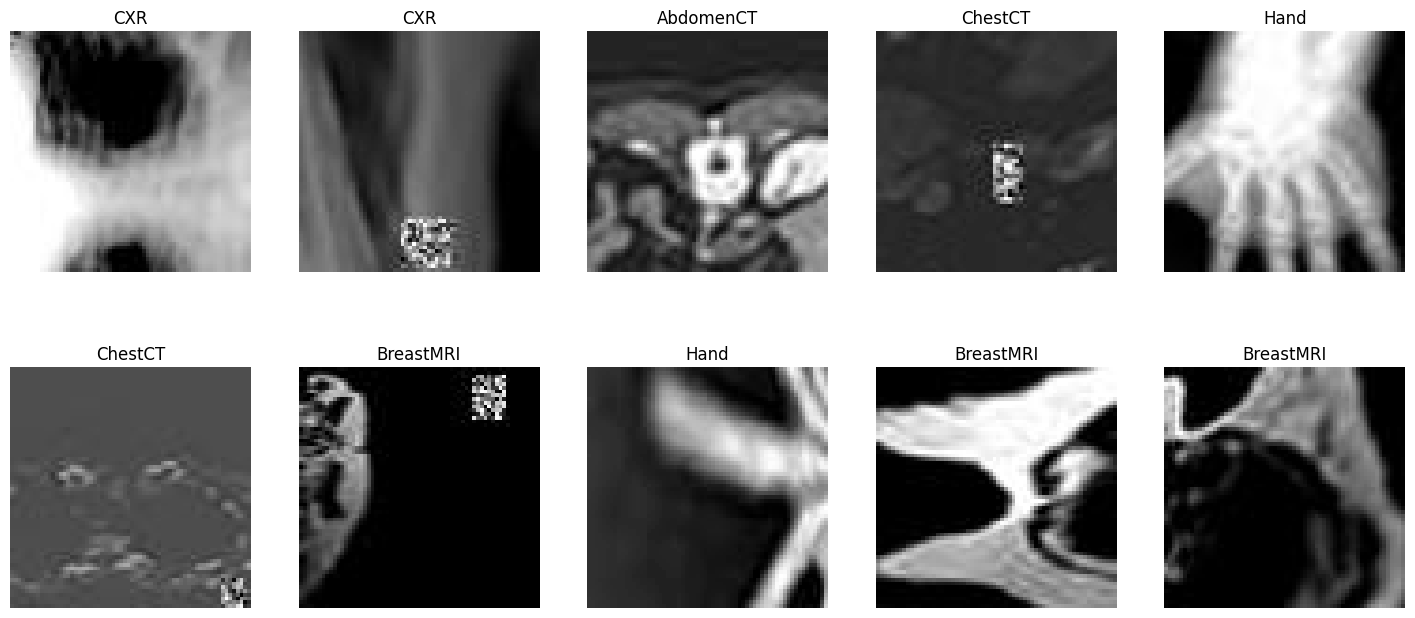

In [ ]:

# Assuming data_df is already loaded and contains 'image-path' and 'labels' columns

# Select 10 random image indices
random_image_indices = random.sample(range(len(data_df)), 10)

# Create a figure and plot the images
plt.figure(figsize=(18, 8))
for i, index in enumerate(random_image_indices):
    plt.subplot(2, 5, i + 1)
    # Read the image using cv2.imread
    image = cv2.imread(data_df['image-path'][index], cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    plt.title(data_df['labels'][index])
    plt.axis('off')

plt.show()

In [ ]:
# Save dataframe
data_df.to_csv('train_metadata.csv', index=False)

In [ ]:
# Path of the tes data
test_data_path = os.path.join(os.getcwd(),"test")
# List sub-directory of augmeneted image
test_dirs = get_path_subdir(test_data_path)

In [ ]:
# Read test images and labels
test_images = []
test_labels = []
for path in test_dirs:
    temp_images = read_images(path)
    test_images.extend(temp_images)
    label = [path.split('/')[-1]]
    test_labels.extend(label*len(temp_images))

In [ ]:
# Create a dataframe
test_data_df = pd.DataFrame(list(zip(test_images, test_labels)), columns=["image-path", "labels"])

In [ ]:
# First five rows
test_data_df.head()

,image-path,labels
0,/content/test/Hand/009244.jpeg,Hand
1,/content/test/Hand/001895.jpeg,Hand
2,/content/test/Hand/009289.jpeg,Hand
3,/content/test/Hand/008819.jpeg,Hand
4,/content/test/Hand/007805.jpeg,Hand


In [ ]:
# Save dataframe
test_data_df.to_csv('test_metadata.csv', index=False)

CNN Architectures

As the images are of x ray and  converted those images in greyscale therefore  started with LeNet as it was also trained on greyscale images and it's architecture is simple., Replacing the tanh activation function with Relu as the tanh might lead to vanishing gradient problem

The Relu activation function has no upper bound. So, it is unbounded on positive side which can be an issue. to tackle this problem Batch Normalization is used in this network.

In [ ]:
def get_modifiedLeNet():
    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=120, kernel_size=(3, 3), activation='relu'))
    model.add(Conv2D(filters=120, kernel_size=(3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(84, activation='tanh'))
    model.add(Dense(6, activation='softmax'))
    model.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

Using Cross Validation to measure the model performance on test data

In [ ]:
# Read metedata
train_df = pd.read_csv('train_metadata.csv')
test_df = pd.read_csv('test_metadata.csv')

In [ ]:
def load_data(image_path, labels, height, width, color=False):
    channel = 0
    if color: channel = 3
    else: channel = 1
    images = []
    for path in image_path:
        img = None
        if not color: img = cv2.imread(path, 0)
        else: img = cv2.imread(path)
        img = cv2.resize(img, (height, width), interpolation=cv2.INTER_AREA)
        img = img.astype('float32')
        img /= 255
        images.append(img)
    images = np.array(images)
    images = images.reshape(images.shape[0], height, width, channel)
    encoder = LabelEncoder()
    classes = encoder.fit_transform(labels)
    return images, classes

In [ ]:
# Split data for K-Fold Cross Validation
def train_and_evaluate(images, classes, model_func, test_images, test_classes, nlabels=6):
    model = model_func()
    model.summary()
    # Declare objecr for Stratified K-Fold Cross validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
    count = 1
    x_test = test_images
    y_test = to_categorical(test_classes, nlabels)
    for train_index, val_index in skf.split(images, classes):
        print("Fold No: ",count)
        x_train, x_val = images[train_index], images[val_index]
        y_train, y_val = classes[train_index], classes[val_index]
        y_train = to_categorical(y_train, nlabels)
        y_val = to_categorical(y_val, nlabels)
        model = model_func()
        checkpointer = ModelCheckpoint(monitor='val_loss', mode = 'min',
                                       filepath=os.path.join(os.getcwd(),'models','best_model{}.keras'.format(count)),
                                       verbose=1, save_best_only=True)
        early_stopping_monitor = EarlyStopping(patience = 10)
        hist = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),
                         validation_batch_size=32,
                         callbacks = [early_stopping_monitor, checkpointer], shuffle=True)
        score = model.evaluate(x_test, y_test, verbose=1)
        print("Accuracy Plot: ")
        plt.plot(hist.history['accuracy'])
        plt.plot(hist.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        count += 1

Test performance

In [ ]:
# Load train images and labels
image_path = train_df['image-path']
labels = train_df['labels']
images, classes = load_data(image_path, labels, 32, 32)

In [ ]:
# Load test images and labels
test_image_path = test_df['image-path']
test_labels = test_df['labels']
test_images, test_classes = load_data(test_image_path, test_labels, 32, 32)

In [ ]:
# Split data for K-Fold Cross Validation
def train_and_evaluate(images, classes, model_func, test_images, test_classes, nlabels=6):
    model = model_func()
    model.summary()
    # Declare objecr for Stratified K-Fold Cross validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=32)
    count = 1
    x_test = test_images
    y_test = to_categorical(test_classes, nlabels)
    for train_index, val_index in skf.split(images, classes):
        print("Fold No: ",count)
        x_train, x_val = images[train_index], images[val_index]
        y_train, y_val = classes[train_index], classes[val_index]
        y_train = to_categorical(y_train, nlabels)
        y_val = to_categorical(y_val, nlabels)
        model = model_func()
        checkpointer = ModelCheckpoint(monitor='val_loss', mode = 'min',
                                       filepath=os.path.join(os.getcwd(),'models','best_model{}.keras'.format(count)),
                                       verbose=1, save_best_only=True)
        early_stopping_monitor = EarlyStopping(patience = 10)
        hist = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val, y_val),
                         validation_batch_size=32,
                         callbacks = [early_stopping_monitor, checkpointer], shuffle=True)
        score = model.evaluate(x_test, y_test, verbose=1)
        y_pred = model.predict(x_test)
        y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels
        y_true_classes = np.argmax(y_test, axis=1)  # Get true class labels


        true_labels = test_classes# Assuming test_labels are one-hot encoded


    # Generate confusion matrix
        cm = confusion_matrix(y_true_classes, y_pred_classes)
        random_image_indices = np.random.choice(len(test_images), 10, replace=False)

# Create a figure and plot the images with predictions and true labels
        plt.figure(figsize=(18, 8))
        for i, index in enumerate(random_image_indices):
          plt.subplot(2, 5, i + 1)
          plt.imshow(test_images[index], cmap='gray')  # Assuming grayscale images
          plt.title(f"Predicted: {y_true_classes[index]}, True: {true_labels[index]}")
          plt.axis('off')

          plt.show()
        print("Accuracy Plot: ")
        plt.plot(hist.history['accuracy'])
        plt.plot(hist.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()
        count += 1

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_48 (Conv2D)                   │ (None, 30, 30, 6)           │              60 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_49 (Conv2D)                   │ (None, 28, 28, 6)           │             330 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 14, 14, 6)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_24               │ (None, 14, 14, 6)           │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_50 (Conv2D)                   │ (None, 12, 12, 16)          │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_51 (Conv2D)                   │ (None, 10, 10, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 5, 5, 16)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_25               │ (None, 5, 5, 16)            │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_52 (Conv2D)                   │ (None, 3, 3, 120)           │          17,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_53 (Conv2D)                   │ (None, 1, 1, 120)           │         129,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_26               │ (None, 1, 1, 120)           │             480 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 84)                  │          10,164 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 6)                   │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 161,952 (632.62 KB)

 Trainable params: 161,668 (631.52 KB)

 Non-trainable params: 284 (1.11 KB)

Fold No:  1


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2249/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6954 - loss: 0.8007
Epoch 1: val_loss improved from inf to 0.40237, saving model to /content/models/best_model1.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.6955 - loss: 0.8006 - val_accuracy: 0.8561 - val_loss: 0.4024
Epoch 2/50
2233/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8536 - loss: 0.3997
Epoch 2: val_loss improved from 0.40237 to 0.35237, saving model to /content/models/best_model1.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8537 - loss: 0.3996 - val_accuracy: 0.8704 - val_loss: 0.3524
Epoch 3/50
2247/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8800 - loss: 0.3252
Epoch 3: val_loss improved from 0.35237 to 0.27732, saving model to /content/models/best_model1.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8800 - loss: 0.3252 - val_accuracy: 0.8962 - val_loss: 0.2773
Epoch 4/50
2243/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8943 - 

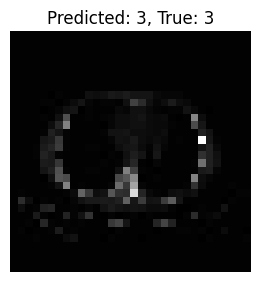

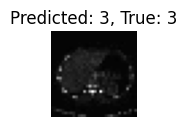

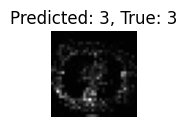

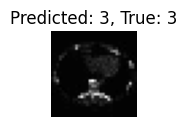

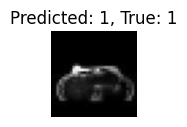

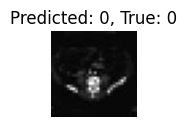

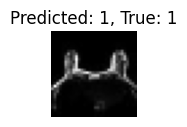

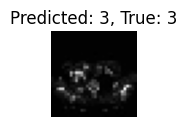

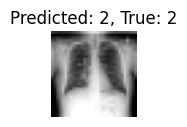

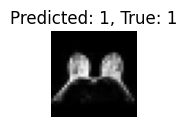

Accuracy Plot: 


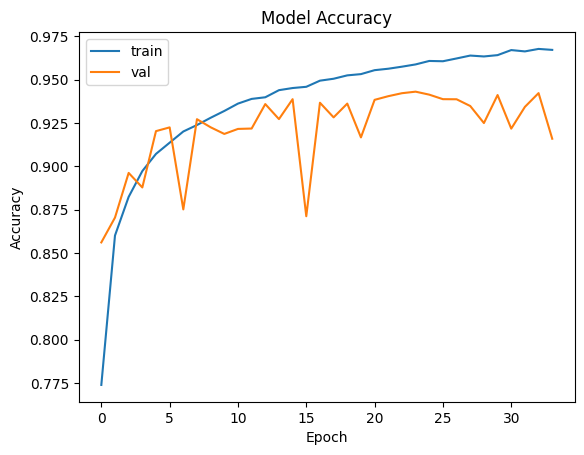

Test loss: 0.1379036009311676
Test accuracy: 0.9477777481079102


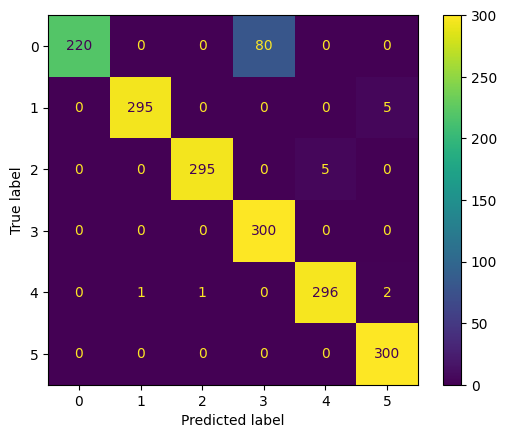

Fold No:  2


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2231/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6896 - loss: 0.8096
Epoch 1: val_loss improved from inf to 0.72361, saving model to /content/models/best_model2.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.6903 - loss: 0.8079 - val_accuracy: 0.7381 - val_loss: 0.7236
Epoch 2/50
2232/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8522 - loss: 0.4073
Epoch 2: val_loss improved from 0.72361 to 0.36339, saving model to /content/models/best_model2.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.8522 - loss: 0.4071 - val_accuracy: 0.8640 - val_loss: 0.3634
Epoch 3/50
2247/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8794 - loss: 0.3290
Epoch 3: val_loss improved from 0.36339 to 0.27606, saving model to /content/models/best_model2.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8794 - loss: 0.3290 - val_accuracy: 0.9027 - val_loss: 0.2761
Epoch 4/50
2240/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8939 - 

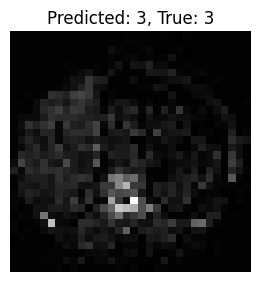

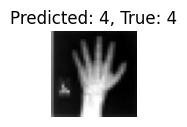

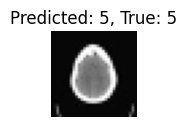

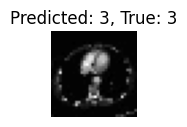

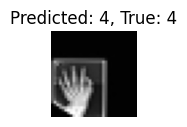

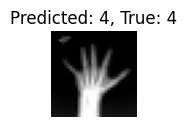

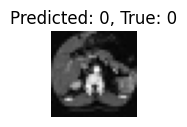

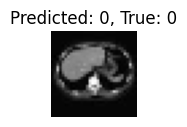

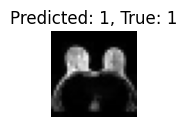

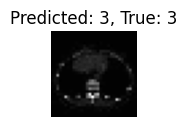

Accuracy Plot: 


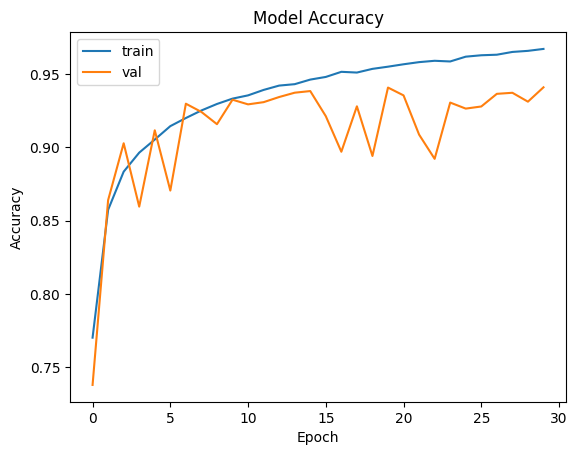

Test loss: 0.039243657141923904
Test accuracy: 0.9866666793823242


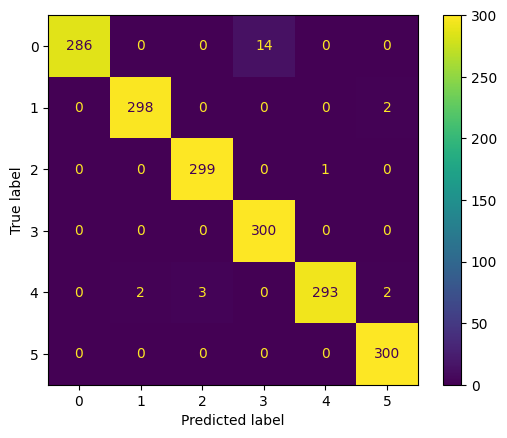

Fold No:  3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2247/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7206 - loss: 0.7397
Epoch 1: val_loss improved from inf to 0.45814, saving model to /content/models/best_model3.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.7208 - loss: 0.7393 - val_accuracy: 0.8278 - val_loss: 0.4581
Epoch 2/50
2237/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8662 - loss: 0.3673
Epoch 2: val_loss did not improve from 0.45814
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8662 - loss: 0.3672 - val_accuracy: 0.6446 - val_loss: 1.1699
Epoch 3/50
2236/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8909 - loss: 0.3003
Epoch 3: val_loss improved from 0.45814 to 0.31105, saving model to /content/models/best_model3.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8909 - loss: 0.3002 - val_accuracy: 0.8873 - val_loss: 0.3111
Epoch 4/50
2244/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9058 - loss: 0.2633
Epoch 4: val_loss improved from 0.31105 to 

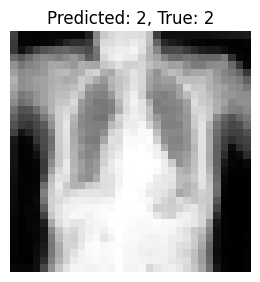

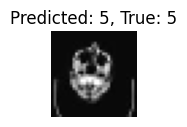

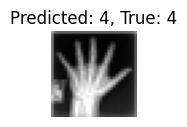

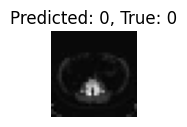

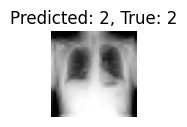

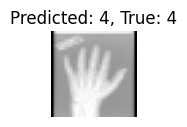

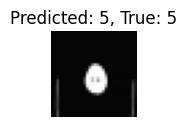

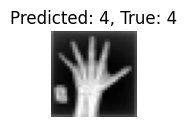

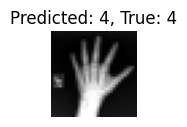

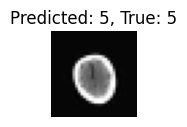

Accuracy Plot: 


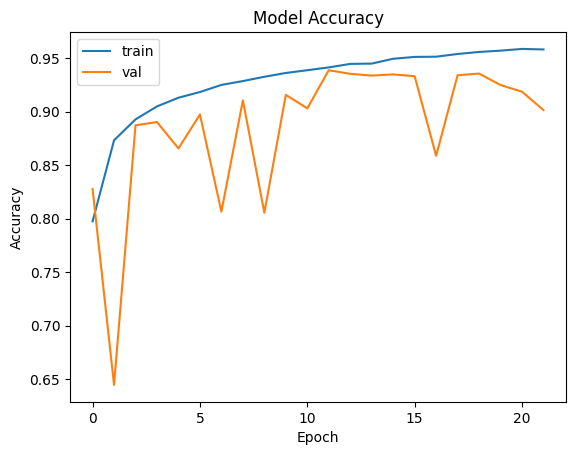

Test loss: 0.057546861469745636
Test accuracy: 0.9866666793823242


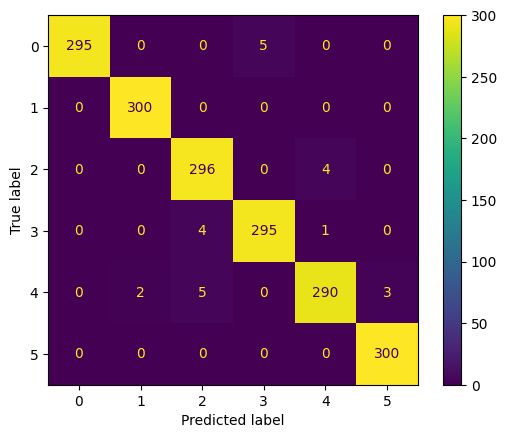

Fold No:  4


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2242/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7059 - loss: 0.7684
Epoch 1: val_loss improved from inf to 0.43807, saving model to /content/models/best_model4.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.7062 - loss: 0.7676 - val_accuracy: 0.8389 - val_loss: 0.4381
Epoch 2/50
2232/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8634 - loss: 0.3774
Epoch 2: val_loss improved from 0.43807 to 0.29122, saving model to /content/models/best_model4.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8634 - loss: 0.3772 - val_accuracy: 0.8966 - val_loss: 0.2912
Epoch 3/50
2241/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8911 - loss: 0.3019
Epoch 3: val_loss did not improve from 0.29122
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8912 - loss: 0.3018 - val_accuracy: 0.8926 - val_loss: 0.2967
Epoch 4/50
2238/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9051 - loss: 0.2642
Epoch 4: val_loss improved from 0.29122 to 

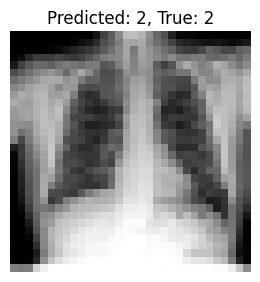

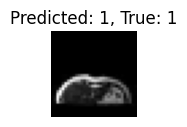

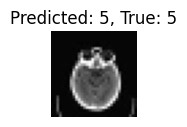

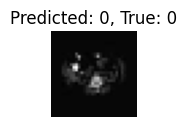

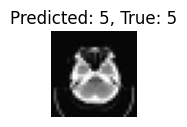

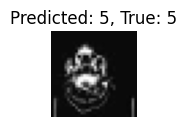

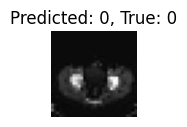

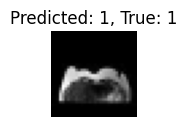

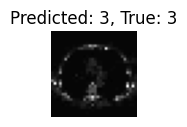

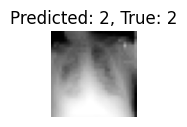

Accuracy Plot: 


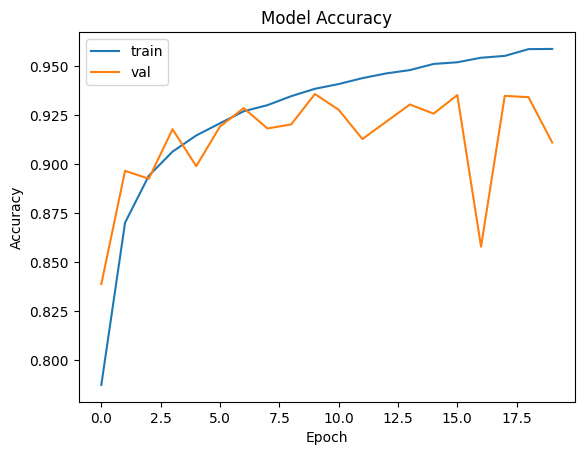

Test loss: 0.13140416145324707
Test accuracy: 0.9483333230018616


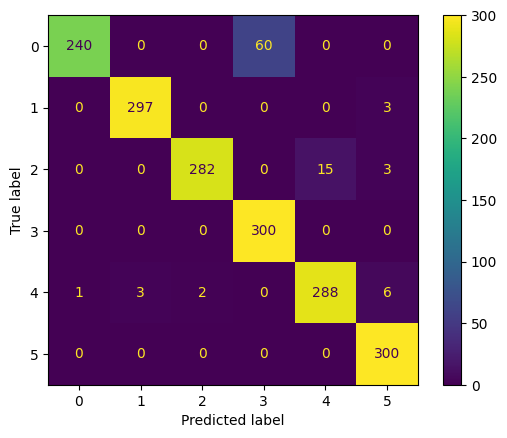

Fold No:  5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2243/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7199 - loss: 0.7334
Epoch 1: val_loss improved from inf to 0.52893, saving model to /content/models/best_model5.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.7202 - loss: 0.7327 - val_accuracy: 0.7987 - val_loss: 0.5289
Epoch 2/50
2245/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8665 - loss: 0.3668
Epoch 2: val_loss improved from 0.52893 to 0.40038, saving model to /content/models/best_model5.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.8666 - loss: 0.3667 - val_accuracy: 0.8519 - val_loss: 0.4004
Epoch 3/50
2249/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8922 - loss: 0.3014
Epoch 3: val_loss improved from 0.40038 to 0.25411, saving model to /content/models/best_model5.keras
2250/2250 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8922 - loss: 0.3014 - val_accuracy: 0.9076 - val_loss: 0.2541
Epoch 4/50
2242/2250 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9051 - l

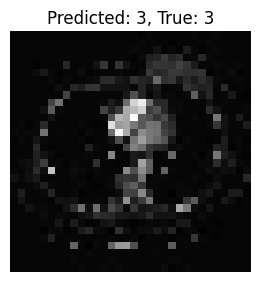

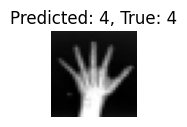

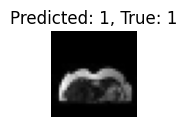

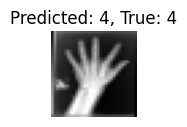

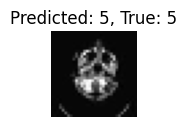

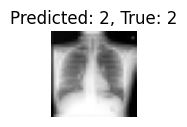

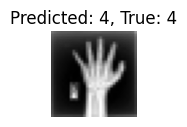

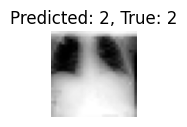

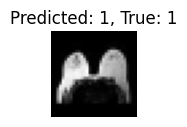

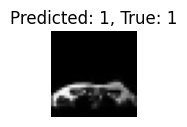

Accuracy Plot: 


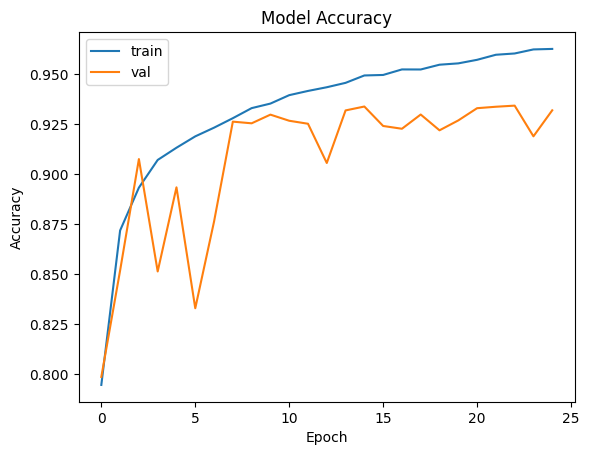

Test loss: 0.041890207678079605
Test accuracy: 0.9833333492279053


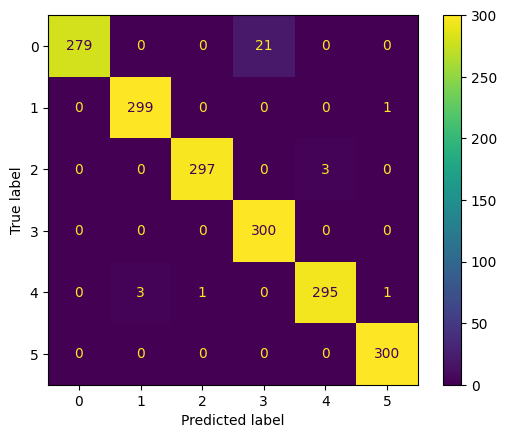

In [ ]:
train_and_evaluate(images,classes, get_modifiedLeNet, test_images, test_classes)